### Instance protrusion segmentation

The task of instance segmentation is to assign to each vertex (or alternatively face) of a mesh a positive integer id with each unique integer id corresponding to a unique protrusion. u-Unwrap3D assumes the convention that the label 0 is used to denote vertices/faces not part of a protrusion i.e. background. Labels > 0 are foreground i.e. all are protrusions.   

We will do instance segmentation by:

1. binary segment protrusion tips as that of the highest positive mean curvature
2. applying connected component analysis to assign binary segmented tips to unique protrusions
3. applying diffusion to propagate this seed labeling to cover the rest of the protrusion

<div class="alert alert-block alert-info"> 
<b>NOTE</b> The procedure is equally applicable whether we use $S(x,y,z)$ or its topography $S(d,u,v)$. However if using we need handle the boundary conditions to avoid a single protrusion being allocated two labels only because of the seam cut.    
</div>

The mesh we we will use to demonstrate is `../../data/mesh/lamellipodia_cell.obj`, as well as its corresponding topography mesh `../../data/mesh/topography/curvature_topographic_mesh_lamellipodia_cell.obj`. The method demonstrated generalizes for all protrusions, but may require tweaking of parameters. 

#### 0. Read in the surface mesh

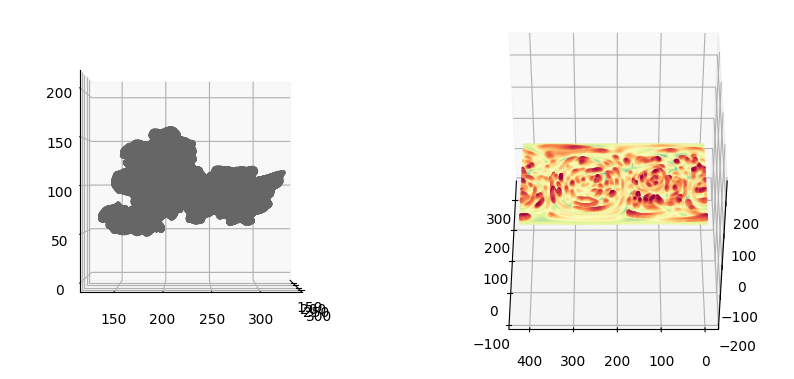

In [1]:
import unwrap3D.Mesh.meshtools as meshtools
import unwrap3D.Analysis_Functions.topography as topotools
import unwrap3D.Segmentation.segmentation as segmentation
import unwrap3D.Image_Functions.image as image_fn
import unwrap3D.Utility_Functions.file_io as fio # for common IO functions
import unwrap3D.Unzipping.unzip as uzip
import unwrap3D.Visualisation.colors as vol_colors
import unwrap3D.Visualisation.plotting as plotting

from matplotlib import cm 
import os
import numpy as np
import pylab as plt 
import skimage.io as skio 
import scipy.io as spio 

"""
Specifying image file location and parsing its name. 
"""
meshfolder = '../../data/mesh'
meshfile = os.path.join(meshfolder, 'lamellipodia_cell.obj')

basefname = os.path.split(meshfile)[-1].split('.obj')[0] # get the filename with extension

mesh_S = meshtools.read_mesh(meshfile,
                             keep_largest_only=True) # read only the largest if there is multiple separate objects in the mesh

"""
Also get its topography mesh
"""
topo_meshfile = os.path.join(meshfolder, 'topography', 'curvature_topographic_mesh_lamellipodia_cell.obj')
mesh_S_duv = meshtools.read_mesh(topo_meshfile, 
                                 keep_largest_only=True)

"""
Also its topography binary volume and the topography space
"""
# read the topography volume image of the cell 
binary_topography_file = os.path.join(meshfolder, 'topography', 'topography_binary.tif')
binary_topography_volume = skio.imread(binary_topography_file)

# read the topography space 
topography_space_file = os.path.join(meshfolder, 'topography', 'topographic_volume_space.mat')
topography_space_obj = spio.loadmat(topography_space_file)

topographic_coordinates = topography_space_obj['topographic_map']

"""
Create a master save folder
"""
savefolder = os.path.join('example_results', 
                          'instance segmentation',
                         basefname)
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Visualize the input mesh
"""
sampling = 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.5, 
            c=mesh_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.5, 
            c=mesh_S_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(45,180)
plotting.set_axes_equal(ax)
plt.show()

#### 1. Measure mean curvature and binary segmentation

The objective is to identify tips or ridges of protrusions which are characterized by high positive mean curvature. We can identify them by applying kmeans clustering to the mean curvature measured either in Cartesian or topography space. The higher the number of clusters, $K$ the finer the binning of mean curvature values and consequently we can set a higher cutoff using the class with highest mean curvature. 

We perform this after voxelization the mesh so that we can use image-based connected component analysis algorithms.

##### $S(x,y,z)$

We first voxelize to get a binary volume from the mesh and use kmeans cluster to detect the positive protrusion tips using k=5.

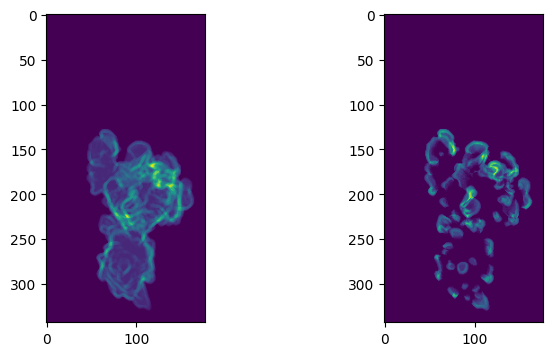

In [2]:
# voxelize to get a binary
mesh_S_binary = meshtools.voxelize_image_mesh_pts(mesh_S, pad=15, 
                                                  dilate_ksize=2,
                                                  erode_ksize=2)

# compute curvature for the entire binary
H_surf_S, (H_binary_3D_S, _, _) = meshtools.compute_mean_curvature_from_binary(mesh_S, 
                                                                mesh_S_binary, 
                                                                smooth_gradient=3, 
                                                                eps=1e-12,
                                                                invert_H=True,
                                                                return_H_img=True)
H_binary_3D_S[np.isnan(H_binary_3D_S)] = 0 # impute nans 


# perform clustering on a shell volume around the surface, more equals setting a higher curvature threshold
n_clusters= 3
# this is another critical parameter in that it allows multi-scale smoothing of the curvature, this can help to segment protrusions over a larger area like lamellipodia
smooth_curvature_sigma=[1.,3.,5.] 

depth_binary_mask, H_binary_clusters = topotools.segment_topography_vol_curvature_surface(H_binary_3D_S, 
                                                                                                mesh_S_binary>0,
                                                                                                depth_ksize=2, # this is the size of shell around the surface 
                                                                                                smooth_curvature_sigma=smooth_curvature_sigma, # multiscale. allows for multiscale
                                                                                                seg_method='kmeans', # or gmm
                                                                                                n_samples=10000, # number of voxel points to sample
                                                                                                n_classes=n_clusters, # number of Kmeans cluster
                                                                                                scale_feats=False)
H_binary_clusters = topotools.remove_topography_segment_objects_binary(H_binary_clusters==np.unique(H_binary_clusters)[-1], # use the highest cluster id (most positive) 
                                                                        minsize=50, # minimum size in voxels.
                                                                        uv_params_depth=None) # don't use if in cartesian, else can use to convert topo to cartesian here

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(depth_binary_mask.mean(axis=0))
plt.subplot(122)
plt.imshow(H_binary_clusters.mean(axis=0))
plt.show()


##### $S(d,u,v)$

<div class="alert alert-block alert-info"> 
<b>NOTE</b> We have two options when using the topography mesh: 

1. measuring and segmenting on the curvature in topography space, or 
2. map the topography mesh into Cartesian to sample the actual 3D mean curvature. 

We will demo option 1. here just to show what topography offers
</div>

(62, 256, 418)


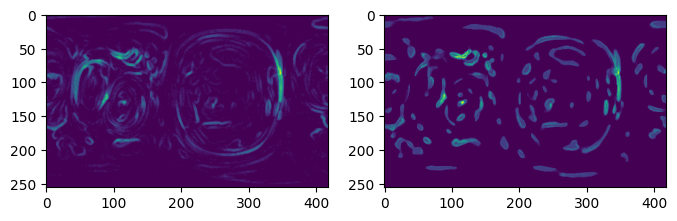

In [3]:
# use the topography binary 
mesh_S_binary_topo = binary_topography_volume>0

# compute curvature for the topography binary
H_surf_S_duv, (H_binary_3D_S_duv, _, _) = meshtools.compute_mean_curvature_from_binary(mesh_S_duv, 
                                                                                        mesh_S_binary_topo, 
                                                                                        smooth_gradient=3, 
                                                                                        eps=1e-12,
                                                                                        invert_H=True,
                                                                                        return_H_img=True)
H_binary_3D_S_duv[np.isnan(H_binary_3D_S_duv)] = 0 # impute nans 


# perform clustering on a shell volume around the surface, more equals setting a higher curvature threshold
n_clusters= 3
# this is another critical parameter in that it allows multi-scale smoothing of the curvature, this can help to segment protrusions over a larger area like lamellipodia
smooth_curvature_sigma=[1.,3.,5.] 

depth_binary_mask_duv, H_binary_clusters_duv = topotools.segment_topography_vol_curvature_surface(H_binary_3D_S_duv, 
                                                                                                mesh_S_binary_topo>0,
                                                                                                depth_ksize=2, # this is the size of shell around the surface 
                                                                                                smooth_curvature_sigma=smooth_curvature_sigma, # multiscale. allows for multiscale
                                                                                                seg_method='kmeans', # or gmm
                                                                                                n_samples=10000, # number of voxel points to sample
                                                                                                n_classes=n_clusters, # number of Kmeans cluster
                                                                                                scale_feats=False)
H_binary_clusters_duv = topotools.remove_topography_segment_objects_binary(H_binary_clusters_duv==np.unique(H_binary_clusters_duv)[-1], # use the highest cluster id (most positive) 
                                                                            minsize=50, # minimum size in voxels in Cartesian
                                                                            uv_params_depth=topographic_coordinates) # don't use if in cartesian, else can use to convert topo to cartesian here

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(depth_binary_mask_duv.mean(axis=0))
plt.subplot(122)
plt.imshow(H_binary_clusters_duv.mean(axis=0))
plt.show()

#### 2. Connected component analysis to label unique protrusion tips

Apply image connected component analysis on the binary volume segmentation of the curvature in Cartesian or topography space to assign unique ids to each contiguous spatial region. These will form the 'seeds' for each individual protrusion and will be diffused in the next step to capture the rest of the protrusion.

##### $S(x,y,z)$

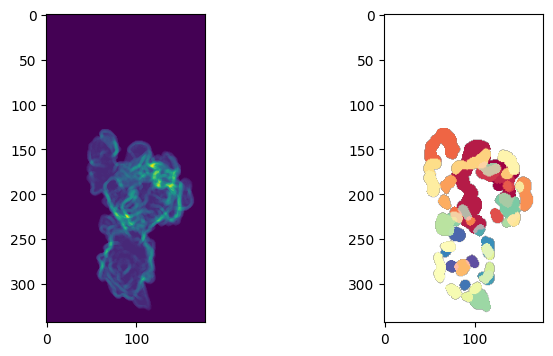

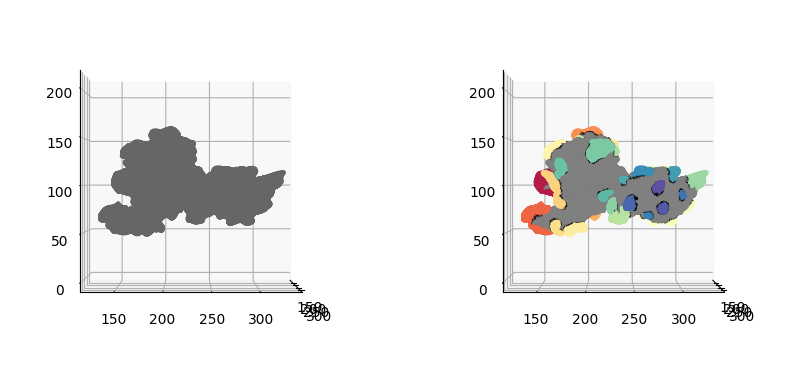

In [4]:
import skimage.measure as skmeasure 
import skimage.segmentation as sksegmentation
import skimage.morphology as skmorph 
import igl

# connected component analysis, then label expansion, to help label a bit more. before diffusion on the mesh
H_binary_clusters_positive_tips = H_binary_clusters==np.unique(H_binary_clusters)[-1]

# gate with binary, remove small regions
protrusion_tips = mesh_S_binary * H_binary_clusters_positive_tips
protrusion_tips = skmorph.remove_small_objects(protrusion_tips, min_size=50)
protrusion_tips = skmeasure.label(protrusion_tips)
protrusion_tips = sksegmentation.expand_labels(protrusion_tips,3)

# to visualize assign colors. 
max_label = np.max(protrusion_tips)
protrusion_tips_color = np.uint8(255*vol_colors.get_colors(protrusion_tips, 
                                                            colormap=cm.Spectral, # use the hsv map. 
                                                            bg_label=0, 
                                                            vmin=1,
                                                            vmax=max_label))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(depth_binary_mask.mean(axis=0))
plt.subplot(122)
plt.imshow(protrusion_tips_color.max(axis=0))
plt.show()


"""
putting the volume-based segmentation back onto the mesh, color and export for visualization
"""
protrusion_labels = image_fn.map_intensity_interp3(mesh_S.vertices, 
                                                    grid_shape=mesh_S_binary.shape, 
                                                    I_ref=protrusion_tips, 
                                                    method='nearest', 
                                                    cast_uint8=False).astype(np.int32)

# assign colors for export
protrusion_labels_color = np.uint8(255*vol_colors.get_colors(protrusion_labels, 
                                                                        colormap=cm.Spectral, 
                                                                        bg_label=0, 
                                                                        vmin=1,vmax=max_label))[...,:3]
# assign gray to background
protrusion_labels_color[protrusion_labels==0] = np.hstack([128,128,128])[None,:] 


"""
colors are redundant, to help distinguish individual protrusions it is better to not color the boundary of each protrusion, setting the color to black
"""
# boundary loop finding works on faces. 
face_labels =  image_fn.map_intensity_interp3(igl.barycenter(mesh_S.vertices, 
                                                            mesh_S.faces), 
                                                        grid_shape=mesh_S_binary.shape, 
                                                        I_ref=protrusion_tips, # do we need to expand labels to be able to sample onto mesh. 
                                                        method='nearest', 
                                                        cast_uint8=False).astype(np.int32)
uniq_labels = np.setdiff1d(np.unique(face_labels),0)

# find all vertices associated with boundary and set the color on vertex to black
vertex_set_0 = []
for lab in uniq_labels:
    b_loop = igl.boundary_loop(mesh_S.faces[face_labels==lab])
    if len(b_loop)>0:
        vertex_set_0.append(b_loop)
vertex_set_0 = np.unique(np.hstack(vertex_set_0))


protrusion_labels_color[vertex_set_0] = np.hstack([0,0,0])[None,:] # set all the boundaries to black

"""
finally export the mesh with color
"""
protrusion_labels_mesh = mesh_S.copy()
protrusion_labels_mesh.visual.vertex_colors = protrusion_labels_color[:,:3].copy()
tmp = protrusion_labels_mesh.export(os.path.join(savefolder,
                                         'instance_segmentation_initial_Cartesian_3D_%s.obj' %(basefname)))

"""
Visualize in matplotlib
"""
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.5, 
            c=mesh_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(protrusion_labels_mesh.vertices[::sampling,0], 
            protrusion_labels_mesh.vertices[::sampling,1],
            protrusion_labels_mesh.vertices[::sampling,2], 
            s=0.5, 
            c=protrusion_labels_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()

##### $S(d,u,v)$

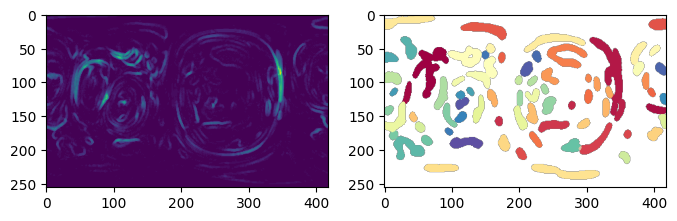

In [5]:
# connected component analysis, then label expansion, to help label a bit more. before diffusion on the mesh
H_binary_clusters_positive_tips_duv = H_binary_clusters_duv==np.unique(H_binary_clusters_duv)[-1]

# gate with binary, remove small regions
protrusion_tips_duv = mesh_S_binary_topo * H_binary_clusters_positive_tips_duv
protrusion_tips_duv = skmorph.remove_small_objects(protrusion_tips_duv, min_size=10)
protrusion_tips_duv = skmeasure.label(protrusion_tips_duv)
protrusion_tips_duv = sksegmentation.expand_labels(protrusion_tips_duv,3)

# to visualize assign colors. 
max_label_duv = np.max(protrusion_tips_duv)
protrusion_tips_color_duv = np.uint8(255*vol_colors.get_colors(protrusion_tips_duv, 
                                                            colormap=cm.Spectral, # use the hsv map. 
                                                            bg_label=0, 
                                                            vmin=1,
                                                            vmax=max_label_duv))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(depth_binary_mask_duv.mean(axis=0))
plt.subplot(122)
plt.imshow(protrusion_tips_color_duv.max(axis=0))
plt.show()


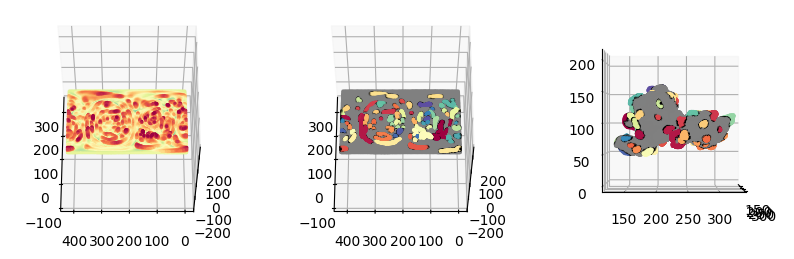

In [6]:

"""
putting the volume-based segmentation back onto the mesh, color and export for visualization
"""
protrusion_labels_duv = image_fn.map_intensity_interp3(mesh_S_duv.vertices, 
                                                    grid_shape=mesh_S_binary_topo.shape, 
                                                    I_ref=protrusion_tips_duv, 
                                                    method='nearest', 
                                                    cast_uint8=False).astype(np.int32)

# assign colors for export
protrusion_labels_color_duv = np.uint8(255*vol_colors.get_colors(protrusion_labels_duv, 
                                                                        colormap=cm.Spectral, 
                                                                        bg_label=0, 
                                                                        vmin=1,vmax=max_label_duv))[...,:3]
# assign gray to background
protrusion_labels_color_duv[protrusion_labels_duv==0] = np.hstack([128,128,128])[None,:] 


"""
colors are redundant, to help distinguish individual protrusions it is better to not color the boundary of each protrusion, setting the color to black
"""
# boundary loop finding works on faces. 
face_labels_duv =  image_fn.map_intensity_interp3(igl.barycenter(mesh_S_duv.vertices, 
                                                            mesh_S_duv.faces), 
                                                        grid_shape=mesh_S_binary_topo.shape, 
                                                        I_ref=protrusion_tips_duv, # do we need to expand labels to be able to sample onto mesh. 
                                                        method='nearest', 
                                                        cast_uint8=False).astype(np.int32)
uniq_labels_duv = np.setdiff1d(np.unique(face_labels_duv),0)

# find all vertices associated with boundary and set the color on vertex to black
vertex_set_0 = []
for lab in uniq_labels_duv:
    b_loop = igl.boundary_loop(mesh_S_duv.faces[face_labels_duv==lab])
    if len(b_loop)>0:
        vertex_set_0.append(b_loop)
vertex_set_0 = np.unique(np.hstack(vertex_set_0))

protrusion_labels_color_duv[vertex_set_0] = np.hstack([0,0,0])[None,:] # set all the boundaries to black

"""
finally export the mesh with color
"""
protrusion_labels_mesh_duv = mesh_S_duv.copy()
protrusion_labels_mesh_duv.visual.vertex_colors = protrusion_labels_color_duv[:,:3].copy()
tmp = protrusion_labels_mesh_duv.export(os.path.join(savefolder,
                                         'instance_segmentation_initial_Topography_3D_%s.obj' %(basefname)))


"""
map the topographic to cartesian for visualization 
"""
mesh_S_duv_to_xyz = topotools.uv_depth_pts3D_to_xyz_pts3D(mesh_S_duv.vertices, topographic_coordinates)

protrusion_labels_mesh_duv_to_xyz = protrusion_labels_mesh_duv.copy()
protrusion_labels_mesh_duv_to_xyz.vertices = mesh_S_duv_to_xyz.copy()
tmp = protrusion_labels_mesh_duv_to_xyz.export(os.path.join(savefolder,
                                         'instance_segmentation_initial_Topography-to-Cartesian_3D_%s.obj' %(basefname)))


"""
Visualize in matplotlib
"""
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.5, 
            c=mesh_S_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(protrusion_labels_mesh_duv.vertices[::sampling,1], 
            protrusion_labels_mesh_duv.vertices[::sampling,2],
            protrusion_labels_mesh_duv.vertices[::sampling,0], 
            s=0.5, 
            c=protrusion_labels_mesh_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(protrusion_labels_mesh_duv_to_xyz.vertices[::sampling,0], 
            protrusion_labels_mesh_duv_to_xyz.vertices[::sampling,1],
            protrusion_labels_mesh_duv_to_xyz.vertices[::sampling,2], 
            s=0.5, 
            c=protrusion_labels_mesh_duv_to_xyz.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()

#### 3. Postprocessing and diffusion of protrusion tips segmentation

u-Unwrap3D adapts [labelspreading](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html) to diffuse the protrusion steps for $n$ steps on a surface mesh given an affinity matrix based on distance and local convexity to refine segmentation to capture more of the protrusions. 

##### $S(x,y,z)$

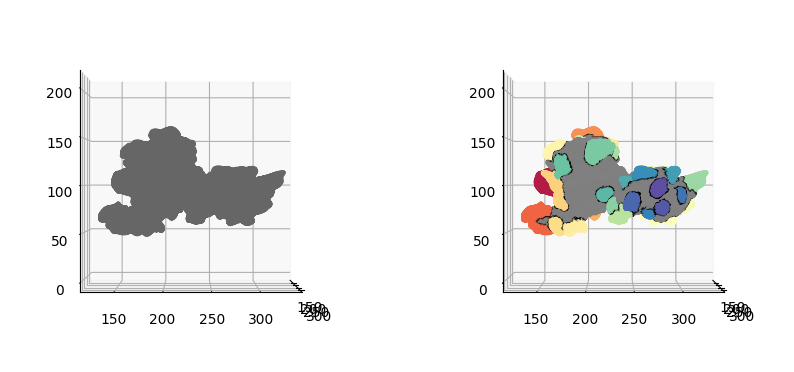

In [7]:
# 1. Filter out small detected protrusions we don't wish to diffuse
protrusion_labels_final = meshtools.remove_small_mesh_components_labels(mesh_S.vertices, 
                                                                        mesh_S.faces, 
                                                                        bg_label=0, # this the background label
                                                                        labels=protrusion_labels, # label 
                                                                        vertex_labels_bool=True, # True, since we are passing vertex based labels
                                                                        physical_size=True, # filter by actual surface area
                                                                        minsize=5, # set smallish
                                                                        keep_largest_only=True) # if there are disconnected regions assigned the same label, keep only the largest


# 2. construct affinity graph and diffuse labels for N iterations.
W_geometry = meshtools.vertex_geometric_affinity_matrix(protrusion_labels_mesh, 
                                                                gamma=None, 
                                                                eps=1e-12, 
                                                                alpha=.1, # <0.5 biases towards convexity
                                                                normalize=True) 
protrusion_labels_final = meshtools.labelspreading_mesh(v=mesh_S.vertices,
                                                        f=mesh_S.faces, 
                                                        x=np.arange(len(mesh_S.vertices))[protrusion_labels_final>0],  # exclude the background.
                                                        y=protrusion_labels_final[protrusion_labels_final>0], 
                                                        W=W_geometry, 
                                                        niters=5, # how many iterations, 10 for the dendritic example
                                                        alpha_prop=.9, # clamping factor, if 1 output identical to input. 
                                                        return_proba=False, 
                                                        renorm=False)

# 3. Second round of filtering out small detected protrusions
protrusion_labels_final = meshtools.remove_small_mesh_components_labels(mesh_S.vertices, 
                                                                        mesh_S.faces, 
                                                                        bg_label=0, # this the background label
                                                                        labels=protrusion_labels_final, # label 
                                                                        vertex_labels_bool=True, # True, since we are passing vertex based labels
                                                                        physical_size=True, # filter by actual surface area
                                                                        minsize=5, # set smallish
                                                                        keep_largest_only=True) # if there are disconnected regions assigned the same label, keep only the largest

# 4. output the mesh with refined labels and its colors
# assign colors for export
protrusion_labels_color = np.uint8(255*vol_colors.get_colors(protrusion_labels_final, 
                                                            colormap=cm.Spectral, 
                                                            bg_label=0, 
                                                            vmin=1,vmax=max_label))[...,:3]
# assign gray to background
protrusion_labels_color[protrusion_labels_final==0] = np.hstack([128,128,128])[None,:] 


"""
again, blacken vertices part of boundary loop
"""
import scipy.stats as spstats
# calculate face labels by taking the mode
face_labels =  spstats.mode(protrusion_labels_final[mesh_S.faces], axis=-1)[0]
uniq_labels = np.setdiff1d(np.unique(face_labels),0)

# find all vertices associated with boundary and set the color on vertex to black
vertex_set_0 = []
for lab in uniq_labels:
    b_loop = igl.boundary_loop(mesh_S.faces[face_labels==lab])
    if len(b_loop)>0:
        vertex_set_0.append(b_loop)
vertex_set_0 = np.unique(np.hstack(vertex_set_0))

protrusion_labels_color[vertex_set_0] = np.hstack([0,0,0])[None,:] # set all the boundaries to black

"""
finally export the mesh with color
"""
protrusion_labels_final_mesh = protrusion_labels_mesh.copy()
protrusion_labels_final_mesh.visual.vertex_colors = protrusion_labels_color[:,:3].copy()
tmp = protrusion_labels_final_mesh.export(os.path.join(savefolder,
                                         'instance_segmentation_final_Cartesian_3D_%s.obj' %(basefname)))

"""
Visualize in matplotlib
"""
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.5, 
            c=mesh_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(protrusion_labels_final_mesh.vertices[::sampling,0], 
            protrusion_labels_final_mesh.vertices[::sampling,1],
            protrusion_labels_final_mesh.vertices[::sampling,2], 
            s=0.5, 
            c=protrusion_labels_final_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()


##### $S(d,u,v)$

We perform diffusion and postprocessing steps after mapping into Cartesian space. 

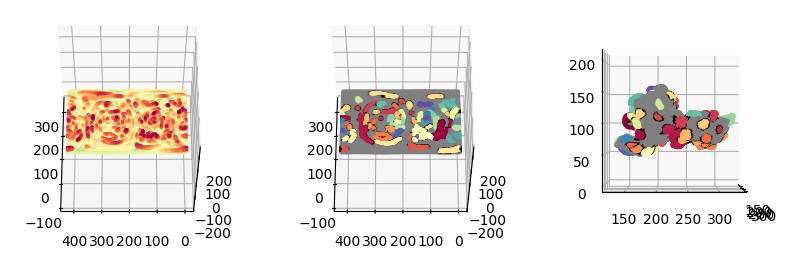

In [8]:
# 1. Filter out small detected protrusions we don't wish to diffuse
protrusion_labels_final_duv = meshtools.remove_small_mesh_components_labels(mesh_S_duv_to_xyz, 
                                                                            mesh_S_duv.faces, 
                                                                            bg_label=0, # this the background label
                                                                            labels=protrusion_labels_duv, # label 
                                                                            vertex_labels_bool=True, # True, since we are passing vertex based labels
                                                                            physical_size=True, # filter by actual surface area
                                                                            minsize=5, # set smallish
                                                                            keep_largest_only=True) # if there are disconnected regions assigned the same label, keep only the largest

# 2. construct affinity graph and diffuse labels for N iterations.
W_geometry_duv = meshtools.vertex_geometric_affinity_matrix(protrusion_labels_mesh_duv, 
                                                                gamma=None, 
                                                                eps=1e-12, 
                                                                alpha=0.1, # <0.5 biases towards convexity, >0.5 biases towards uniform
                                                                normalize=True) 
protrusion_labels_final_duv = meshtools.labelspreading_mesh(v=mesh_S_duv_to_xyz,
                                                            f=mesh_S_duv.faces, 
                                                            x=np.arange(len(mesh_S_duv.vertices))[protrusion_labels_final_duv>0],  # exclude the background.
                                                            y=protrusion_labels_final_duv[protrusion_labels_final_duv>0], 
                                                            W=W_geometry_duv, 
                                                            niters=3, # how many iterations, can use less can use more.
                                                            alpha_prop=.9, # clamping factor, if 1 output identical to input. 
                                                            return_proba=False, 
                                                            renorm=False)

# 3. Second round of filtering out small detected protrusions
protrusion_labels_final_duv = meshtools.remove_small_mesh_components_labels(mesh_S_duv_to_xyz, 
                                                                            mesh_S_duv.faces, 
                                                                            bg_label=0, # this the background label
                                                                            labels=protrusion_labels_final_duv, # label 
                                                                            vertex_labels_bool=True, # True, since we are passing vertex based labels
                                                                            physical_size=True, # filter by actual surface area
                                                                            minsize=5, # set smallish
                                                                            keep_largest_only=True) # if there are disconnected regions assigned the same label, keep only the largest

# 4. output the mesh with refined labels and its colors
# assign colors for export
protrusion_labels_color_duv = np.uint8(255*vol_colors.get_colors(protrusion_labels_final_duv, 
                                                                colormap=cm.Spectral, 
                                                                bg_label=0, 
                                                                vmin=1,vmax=max_label_duv))[...,:3]
# assign gray to background
protrusion_labels_color_duv[protrusion_labels_final_duv==0] = np.hstack([128,128,128])[None,:] 


"""
again, blacken vertices part of boundary loop
"""
import scipy.stats as spstats
# calculate face labels by taking the mode
face_labels_duv =  spstats.mode(protrusion_labels_final_duv[mesh_S_duv.faces], axis=-1)[0]
uniq_labels_duv = np.setdiff1d(np.unique(face_labels_duv),0)

# find all vertices associated with boundary and set the color on vertex to black
vertex_set_0 = []
for lab in uniq_labels:
    b_loop = igl.boundary_loop(mesh_S_duv.faces[face_labels_duv==lab])
    if len(b_loop)>0:
        vertex_set_0.append(b_loop)
vertex_set_0 = np.unique(np.hstack(vertex_set_0))

protrusion_labels_color_duv[vertex_set_0] = np.hstack([0,0,0])[None,:] # set all the boundaries to black

"""
finally export the mesh with color
"""
protrusion_labels_final_mesh_duv = protrusion_labels_mesh_duv.copy()
protrusion_labels_final_mesh_duv.visual.vertex_colors = protrusion_labels_color_duv[:,:3].copy()
tmp = protrusion_labels_final_mesh_duv.export(os.path.join(savefolder,
                                         'instance_segmentation_final_Topography_3D_%s.obj' %(basefname)))

"""
map topography coordinates to cartesian
"""
protrusion_labels_final_mesh_duv_to_xyz = protrusion_labels_final_mesh_duv.copy()
protrusion_labels_final_mesh_duv_to_xyz.vertices = mesh_S_duv_to_xyz.copy()
tmp = protrusion_labels_final_mesh_duv_to_xyz.export(os.path.join(savefolder,
                                         'instance_segmentation_final_Topography-to-Cartesian_3D_%s.obj' %(basefname)))

"""
Visualize in matplotlib
"""
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.5, 
            c=mesh_S_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(protrusion_labels_final_mesh_duv.vertices[::sampling,1], 
            protrusion_labels_final_mesh_duv.vertices[::sampling,2],
            protrusion_labels_final_mesh_duv.vertices[::sampling,0], 
            s=0.5, 
            c=protrusion_labels_final_mesh_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(protrusion_labels_final_mesh_duv_to_xyz.vertices[::sampling,0], 
            protrusion_labels_final_mesh_duv_to_xyz.vertices[::sampling,1],
            protrusion_labels_final_mesh_duv_to_xyz.vertices[::sampling,2], 
            s=0.5, 
            c=protrusion_labels_final_mesh_duv_to_xyz.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()

#### 4. Correcting the segmentation at boundary when using $S(d,u,v)$

Due to unwrapping effectively cutting open the 3D closed surface, and thereby breaking symmetry, any protrusions spanning the 'seam' i.e. lies at the boundary of $(d,u,v)$ space may be assigned two different labels i.e. two different protrusions when segmenting using $S(d,u,v)$ instead of being identified as one label and one unique protrusion as it really is.

We will fix this by flattening the mesh onto the 2D plane, and taking account the boundary conditions. Specifically,

1. topographic cMCF to flatten topography mesh
2. resample label as a 2D label image
3. implement the boundary condition on all four edges and test for whether labels should be merged  
4. transfer corrected labels to the topographic mesh via the flattened topographic cMCF

<div class="alert alert-block alert-info"> 
<b>NOTE</b> Correcting the boundary segmentations necessarily means introducing multi-component (>1 contiguous spatial region) protrusions in topography and uv spaces. We recommend only doing this after conducting all upstream operations that depend on or assume single-component segmentations. This is why we leave it last.    
</div>

##### 1. Topographic cMCF to flatten topography mesh

c:\Users\s205272\AppData\Local\miniconda3\envs\unwrap3d_test_py310_noskfmm\lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


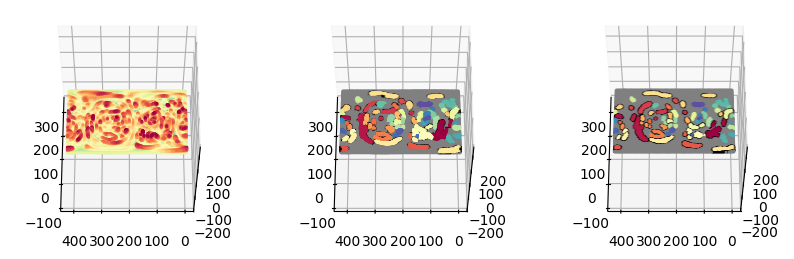

In [9]:
Usteps, F, flow_metrics_dict = meshtools.conformalized_mean_curvature_flow_topography(protrusion_labels_final_mesh_duv, 
                                                                                    max_iter=10, 
                                                                                    delta=1e4, 
                                                                                    conformalize = True, 
                                                                                    robust_L =True, 
                                                                                    mollify_factor=1e-5)

protrusion_labels_final_mesh_duv_flat = protrusion_labels_final_mesh_duv.copy()
protrusion_labels_final_mesh_duv_flat.vertices = Usteps[...,-1].copy()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.5, 
            c=mesh_S_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(protrusion_labels_final_mesh_duv.vertices[::sampling,1], 
            protrusion_labels_final_mesh_duv.vertices[::sampling,2],
            protrusion_labels_final_mesh_duv.vertices[::sampling,0], 
            s=0.5, 
            c=protrusion_labels_final_mesh_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(protrusion_labels_final_mesh_duv_flat.vertices[::sampling,1], 
            protrusion_labels_final_mesh_duv_flat.vertices[::sampling,2],
            protrusion_labels_final_mesh_duv_flat.vertices[::sampling,0], 
            s=0.5, 
            c=protrusion_labels_final_mesh_duv_flat.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()

##### 2. Resample labels using flattened mesh to 2D image

(256, 418)


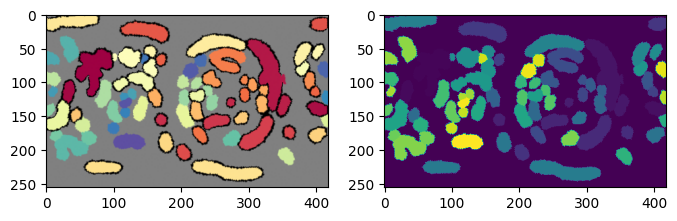

In [10]:
# set up the (d=const., u, v) image grid. 
img_grid_d = np.nanmean(protrusion_labels_final_mesh_duv_flat.vertices[:,0]) # average d
img_grid_v, img_grid_u = np.indices(topographic_coordinates.shape[1:3]) 
print(img_grid_v.shape)
img_grid_duv = np.dstack([img_grid_d*np.ones(img_grid_u.shape), 
                          img_grid_v,
                          img_grid_u])

# transfer, using meshtools.transfer_mesh_measurements
match_params, remapped_protrusion_label_colors, remapped_labels = meshtools.transfer_mesh_measurements(source_mesh=protrusion_labels_final_mesh_duv_flat, # flattened mesh
                                                                                            target_mesh_vertices=img_grid_duv.reshape(-1,3), # augmented 2D grid
                                                                                            source_mesh_vertex_scalars=protrusion_labels_final_mesh_duv_flat.visual.vertex_colors[:,:3],
                                                                                            source_mesh_vertex_labels=protrusion_labels_final_duv[:,None])

remapped_labels = remapped_labels[:,0] # since labels is only one dimension
protrusion_labels_final_duv_to_uv = remapped_labels.reshape(img_grid_duv.shape[:-1])
remapped_protrusion_label_colors = remapped_protrusion_label_colors.reshape(img_grid_duv.shape[:-1]+(3,))
remapped_protrusion_label_colors = np.uint8(remapped_protrusion_label_colors)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(remapped_protrusion_label_colors)
plt.subplot(122)
plt.imshow(protrusion_labels_final_duv_to_uv)
plt.show()

##### 3. Implement boundary conditions and test for label merging 

The boundary conditions of the 2D uv map is:

- periodic for left, right
- for top: left-side joins to right-side
- for bottom left-side joins to right-side

u-Unwrap3D provides the single function `unwrap3D.Unzipping.unzip.correct_border_uv_segmentations` to implement these boundary conditions and check for all segmentations that should be merged based on spatial overlap. 

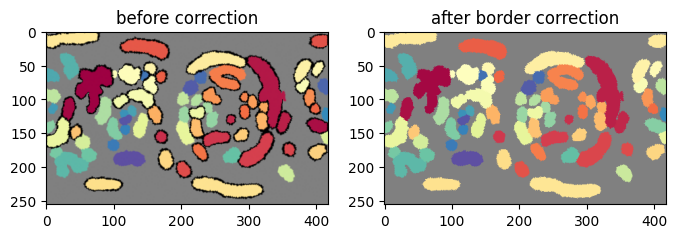

In [17]:
protrusion_labels_final_duv_to_uv_corrected = uzip.correct_border_uv_segmentations(protrusion_labels_final_duv_to_uv, 
                                                                                    border_size=10,
                                                                                    dilate_ksize=1, 
                                                                                    min_size=10, 
                                                                                    S_uv=None, 
                                                                                    use_real_size=False)


# recolor the corrected and visualize side by side
protrusion_labels_final_duv_to_uv_corrected_color = np.uint8(255.*vol_colors.get_colors(protrusion_labels_final_duv_to_uv_corrected, 
                                                                      colormap=cm.Spectral, 
                                                                      vmin=0, vmax=max_label_duv)[...,:3])
protrusion_labels_final_duv_to_uv_corrected_color[protrusion_labels_final_duv_to_uv_corrected==0] = np.hstack([128,128,128])[None,...]

# some of the labels on the right has now been reassigned to the labels on the left they should belong to. 
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.title('before correction')
plt.imshow(remapped_protrusion_label_colors)
plt.subplot(122)
plt.title('after border correction')
plt.imshow(protrusion_labels_final_duv_to_uv_corrected_color)
plt.show()

##### 4. Transfer corrected labels back to the topographic mesh 

The transfer is carried out by noting the flattened topographic cMCF is 1-to-1 with topographic mesh i.e. same number of vertices, no change in face connectivity. Thus we interpolate the label corresponding to the $(u,v)$ coordinates of the flattened topographic cMCF by nearest interpolation.

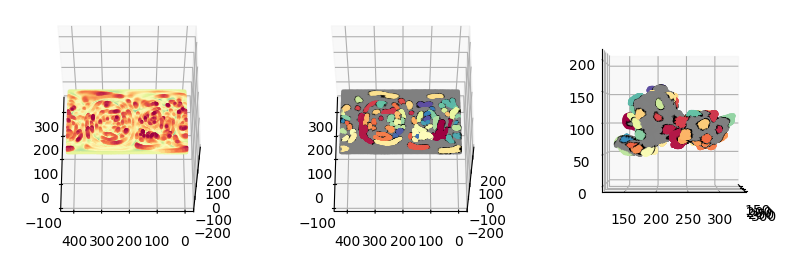

In [27]:
protrusion_labels_final_duv_corrected = image_fn.map_intensity_interp2(protrusion_labels_final_mesh_duv_flat.vertices[:,1:], 
                                                                       grid_shape=protrusion_labels_final_duv_to_uv_corrected.shape[:2], 
                                                                       I_ref=protrusion_labels_final_duv_to_uv_corrected, 
                                                                       method='nearest').astype(np.int32)

# regenerate the coloring
protrusion_labels_final_duv_corrected_color = np.uint8(255*vol_colors.get_colors(protrusion_labels_final_duv_corrected, 
                                                                                colormap=cm.Spectral, 
                                                                                bg_label=0, 
                                                                                vmin=1,vmax=max_label_duv))[...,:3]
# assign gray to background
protrusion_labels_final_duv_corrected_color[protrusion_labels_final_duv_corrected==0] = np.hstack([128,128,128])[None,:] 

"""
again, blacken vertices part of boundary loop
"""
import scipy.stats as spstats
# calculate face labels by taking the mode
face_labels_duv =  spstats.mode(protrusion_labels_final_duv_corrected[mesh_S_duv.faces], axis=-1)[0]
uniq_labels_duv = np.setdiff1d(np.unique(face_labels_duv),0)

# find all vertices associated with boundary and set the color on vertex to black
vertex_set_0 = []
for lab in uniq_labels_duv:
    b_loop = igl.boundary_loop(mesh_S_duv.faces[face_labels_duv==lab])
    if len(b_loop)>0:
        vertex_set_0.append(b_loop)
vertex_set_0 = np.unique(np.hstack(vertex_set_0))

protrusion_labels_final_duv_corrected_color[vertex_set_0] = np.hstack([0,0,0])[None,:] # set all the boundaries to black


"""
finally export the mesh with color
"""
protrusion_labels_final_mesh_duv_corrected = protrusion_labels_final_mesh_duv.copy()
protrusion_labels_final_mesh_duv_corrected.visual.vertex_colors = protrusion_labels_final_duv_corrected_color[:,:3].copy()
tmp = protrusion_labels_final_mesh_duv_corrected.export(os.path.join(savefolder,
                                             'instance_segmentation_final-corrected_Topography_3D_%s.obj' %(basefname)))

"""
map topography coordinates to cartesian
"""
protrusion_labels_final_mesh_duv_to_xyz_corrected = protrusion_labels_final_mesh_duv_corrected.copy()
protrusion_labels_final_mesh_duv_to_xyz_corrected.vertices = mesh_S_duv_to_xyz.copy()
tmp = protrusion_labels_final_mesh_duv_to_xyz_corrected.export(os.path.join(savefolder,
                                                  'instance_segmentation_final-corrected_Topography-to-Cartesian_3D_%s.obj' %(basefname)))

"""
Visualize in matplotlib
"""
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.5, 
            c=mesh_S_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(protrusion_labels_final_mesh_duv_corrected.vertices[::sampling,1], 
            protrusion_labels_final_mesh_duv_corrected.vertices[::sampling,2],
            protrusion_labels_final_mesh_duv_corrected.vertices[::sampling,0], 
            s=0.5, 
            c=protrusion_labels_final_mesh_duv_corrected.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(protrusion_labels_final_mesh_duv_to_xyz_corrected.vertices[::sampling,0], 
            protrusion_labels_final_mesh_duv_to_xyz_corrected.vertices[::sampling,1],
            protrusion_labels_final_mesh_duv_to_xyz_corrected.vertices[::sampling,2], 
            s=0.5, 
            c=protrusion_labels_final_mesh_duv_to_xyz_corrected.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()
